# ADX 趋势因子测试

基于 ADX (Average Directional Index) 的趋势因子测试：
1. 计算 ADX 趋势强度指标（带方向性）
2. 应用不同的归一化方法（线性、log、tanh）
3. 分位数测试和极端组筛选
4. 组合回测和性能分析


In [11]:
# 导入库和设置路径
import sys
from pathlib import Path
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# 添加项目根目录到路径
project_root = Path().resolve().parent.parent
sys.path.append(str(project_root))

# 重新加载模块（确保使用最新代码）
import importlib
if 'research.backtest.signals' in sys.modules:
    importlib.reload(sys.modules['research.backtest.signals'])
if 'research.backtest.portfolio_bt' in sys.modules:
    importlib.reload(sys.modules['research.backtest.portfolio_bt'])
if 'research.backtest.factor_test' in sys.modules:
    importlib.reload(sys.modules['research.backtest.factor_test'])
if 'research.factors.adx' in sys.modules:
    importlib.reload(sys.modules['research.factors.adx'])

# 导入项目模块
from research.factors.adx import ADXFactor
from research.backtest.signals import (
    normalize_factor,
    normalize_positions
)
from research.backtest.factor_test import (
    calculate_ic,
    calculate_ir,
    factor_returns_by_quantile
)
from research.backtest.portfolio_bt import (
    simulate_portfolio,
    calculate_metrics,
    load_backtest_config,
    load_costs_config
)

print("✓ 所有模块导入成功！")
print(f"项目根目录: {project_root}")


✓ 所有模块导入成功！
项目根目录: C:\Users\Chengyu Gong\Klpha\KlphaOriginal


## 步骤 1: 加载数据


In [12]:
# 加载数据
data_path = project_root / "data" / "processed" / "data.pkl"

print(f"加载数据: {data_path}")
with open(data_path, 'rb') as f:
    data = pickle.load(f)

print(f"\n数据包含的字段: {list(data.keys())}")
print(f"\n数据统计:")
for key, df in data.items():
    if isinstance(df, pd.DataFrame):
        print(f"  {key}: {df.shape[0]} 行 × {df.shape[1]} 列")
        print(f"    日期范围: {df.index.min()} 到 {df.index.max()}")


加载数据: C:\Users\Chengyu Gong\Klpha\KlphaOriginal\data\processed\data.pkl

数据包含的字段: ['close', 'open', 'high', 'low', 'volume']

数据统计:
  close: 2763 行 × 501 列
    日期范围: 2015-01-02 00:00:00-05:00 到 2025-12-26 00:00:00-05:00
  open: 2763 行 × 501 列
    日期范围: 2015-01-02 00:00:00-05:00 到 2025-12-26 00:00:00-05:00
  high: 2763 行 × 501 列
    日期范围: 2015-01-02 00:00:00-05:00 到 2025-12-26 00:00:00-05:00
  low: 2763 行 × 501 列
    日期范围: 2015-01-02 00:00:00-05:00 到 2025-12-26 00:00:00-05:00
  volume: 2763 行 × 501 列
    日期范围: 2015-01-02 00:00:00-05:00 到 2025-12-26 00:00:00-05:00


## 步骤 2: 计算 ADX 因子


In [13]:
print("=" * 60)
print("计算 ADX 因子")
print("=" * 60)

# 创建 ADX 因子（参数可调）
adx_factor = ADXFactor(
    period=14,        # ADX 计算周期（14天）
    min_adx=25,       # 最小 ADX 值（过滤弱趋势）
    max_adx=75        # 最大 ADX 值（过滤异常强趋势）
)

print(f"ADX 参数:")
print(f"  周期: {adx_factor.period} 天")
print(f"  ADX 范围: [{adx_factor.min_adx}, {adx_factor.max_adx}]")

# 计算因子值
print(f"\n开始计算 ADX 因子（这可能需要一些时间）...")
factor_values = adx_factor.calculate(data)

print(f"\n✓ ADX 因子计算完成")
print(f"  因子值形状: {factor_values.shape}")
print(f"  均值: {factor_values.mean().mean():.6f}")
print(f"  标准差: {factor_values.std().mean():.6f}")
print(f"  缺失值比例: {factor_values.isna().sum().sum() / factor_values.size * 100:.2f}%")

# 查看因子值分布
adx_vals = factor_values.stack()
print(f"\n因子值统计:")
print(adx_vals.describe())


计算 ADX 因子
ADX 参数:
  周期: 14 天
  ADX 范围: [25, 75]

开始计算 ADX 因子（这可能需要一些时间）...

✓ ADX 因子计算完成
  因子值形状: (2763, 501)
  均值: 5.883641
  标准差: 33.646363
  缺失值比例: 63.43%

因子值统计:
count    506181.000000
mean          5.906539
std          34.113463
min         -74.967233
25%         -29.757232
50%          26.596894
75%          33.685898
max          74.948240
dtype: float64


## 步骤 3: 归一化处理（线性、log、tanh）


In [14]:
print("=" * 60)
print("ADX 因子归一化处理")
print("=" * 60)

# 不填充缺失值，保留 NaN（NaN 表示 ADX 不在有效区间 [25, 75]，这是有意的筛选）
factor_clean = factor_values.copy()  # 直接使用原始因子值
print(f"✓ 保留原始 NaN（NaN 表示 ADX 不在有效区间 [{adx_factor.min_adx}, {adx_factor.max_adx}]，无效趋势信号）")

# 定义 ADX 特定的归一化函数（基于原始 notebook 的思路）
def linear_normalize_adx(adx_df, min_val=25, max_val=75):
    """
    对 [-75, -25] ∪ [25, 75] 区间的 ADX 值进行线性归一化
    映射为 [-1, 1] 区间
    注意：NaN 会被保留，不会被归一化（NaN 表示无效趋势信号）
    """
    abs_val = adx_df.abs()
    normalized = (abs_val - min_val) / (max_val - min_val)
    normalized = normalized.clip(lower=0, upper=1)
    linear_norm_df = normalized * np.sign(adx_df)
    return linear_norm_df.where(~adx_df.isna())  # 保留原始 NaN

def log_normalize_adx(adx_df, min_val=25, max_val=75):
    """
    对 ADX 值进行 log1p 归一化
    注意：NaN 会被保留，不会被归一化
    """
    abs_val = adx_df.abs()
    normalized = np.log1p(abs_val - min_val) / np.log1p(max_val - min_val)
    log_norm_df = normalized * np.sign(adx_df)
    return log_norm_df.where(~adx_df.isna())  # 保留原始 NaN

def tanh_normalize_adx(adx_df, min_val=25, max_val=75):
    """
    对 ADX 值进行 tanh 归一化
    注意：NaN 会被保留，不会被归一化
    """
    abs_val = adx_df.abs()
    scaled = (abs_val - min_val) / (max_val - min_val)
    scaled = scaled.clip(lower=0, upper=1)
    amplified = (scaled - 0.5) * 4  # 映射到 [-2, 2]
    normalized = np.tanh(amplified)
    tanh_norm_df = normalized * np.sign(adx_df)
    return tanh_norm_df.where(~adx_df.isna())  # 保留原始 NaN

# 应用不同的归一化方法
print("\n应用归一化方法...")
linear_normalized = linear_normalize_adx(factor_clean)
log_normalized = log_normalize_adx(factor_clean)
tanh_normalized = tanh_normalize_adx(factor_clean)

print(f"✓ 归一化完成")
print(f"\n线性归一化统计:")
print(linear_normalized.stack().describe())
print(f"\nLog 归一化统计:")
print(log_normalized.stack().describe())
print(f"\nTanh 归一化统计:")
print(tanh_normalized.stack().describe())

# 选择使用的归一化方法（可以切换测试）
normalize_method = 'linear'  # 可选: 'linear', 'log', 'tanh'
if normalize_method == 'linear':
    factor_normalized = linear_normalized
elif normalize_method == 'log':
    factor_normalized = log_normalized
else:
    factor_normalized = tanh_normalized

print(f"\n使用归一化方法: {normalize_method}")


ADX 因子归一化处理
✓ 保留原始 NaN（NaN 表示 ADX 不在有效区间 [25, 75]，无效趋势信号）

应用归一化方法...
✓ 归一化完成

线性归一化统计:
count    506181.000000
mean          0.040816
std           0.227799
min          -0.999345
25%          -0.095145
50%           0.031938
75%           0.173718
max           0.998965
dtype: float64

Log 归一化统计:
count    506181.000000
mean          0.093573
std           0.536083
min          -0.999837
25%          -0.445202
50%           0.242716
75%           0.577511
max           0.999742
dtype: float64

Tanh 归一化统计:
count    506181.000000
mean         -0.092567
std           0.825510
min          -0.964027
25%          -0.907827
50%          -0.488624
75%           0.881493
max           0.964027
dtype: float64

使用归一化方法: linear


分位数测试


C:\Users\Chengyu Gong\AppData\Local\Temp\ipykernel_31336\2505181518.py:7: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  forward_returns = data['close'].pct_change(forward_window).shift(-forward_window)



分位数年化收益 (10组):
  Q1: 90.60%
  Q2: 88.69%
  Q3: 108.89%
  Q4: 91.42%
  Q5: 86.81%
  Q6: 67.95%
  Q7: 61.55%
  Q8: 72.88%
  Q9: 73.63%
  Q10: 56.05%
  多空收益 (Q10-Q1): -34.55%


C:\Users\Chengyu Gong\AppData\Local\Temp\ipykernel_31336\2505181518.py:32: UserWarning: Glyph 20998 (\N{CJK UNIFIED IDEOGRAPH-5206}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Chengyu Gong\AppData\Local\Temp\ipykernel_31336\2505181518.py:32: UserWarning: Glyph 20301 (\N{CJK UNIFIED IDEOGRAPH-4F4D}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Chengyu Gong\AppData\Local\Temp\ipykernel_31336\2505181518.py:32: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Chengyu Gong\AppData\Local\Temp\ipykernel_31336\2505181518.py:32: UserWarning: Glyph 32452 (\N{CJK UNIFIED IDEOGRAPH-7EC4}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Chengyu Gong\AppData\Local\Temp\ipykernel_31336\2505181518.py:32: UserWarning: Glyph 26368 (\N{CJK UNIFIED IDEOGRAPH-6700}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Chengyu Gong\AppData\Local\Temp\ipykernel_31336\250

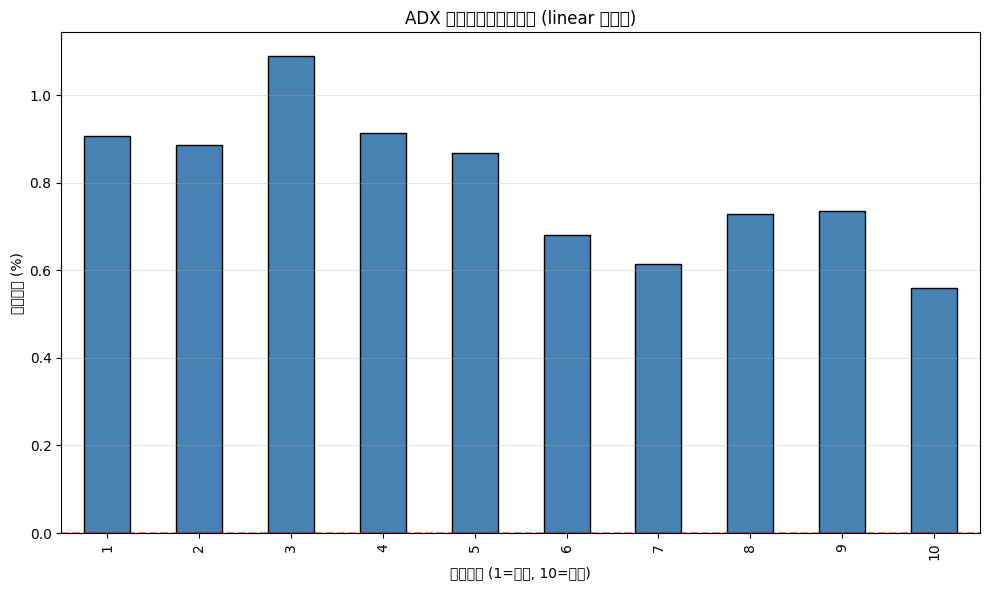


筛选最低3组 (Q1, Q2, Q3)，只做多策略...
✓ 筛选完成（只保留 Q1, Q2, Q3）
  筛选前有效值: 506181
  筛选后有效值: 150647
  保留比例: 29.76%


In [15]:
print("=" * 60)
print("分位数测试")
print("=" * 60)

# 计算未来收益（用于评估因子）
forward_window = 5  # 未来5天收益
forward_returns = data['close'].pct_change(forward_window).shift(-forward_window)

# 分位数分析（10组）
n_quantiles = 10
quantile_returns = factor_returns_by_quantile(
    factor_normalized, 
    forward_returns, 
    n_quantiles=n_quantiles
)

quantile_annual = quantile_returns.mean() * 252

print(f"\n分位数年化收益 (10组):")
for q, ret in quantile_annual.items():
    print(f"  Q{q}: {ret*100:.2f}%")
print(f"  多空收益 (Q10-Q1): {(quantile_annual.iloc[-1] - quantile_annual.iloc[0])*100:.2f}%")

# 可视化分位数收益
plt.figure(figsize=(10, 6))
quantile_annual.plot(kind='bar', color='steelblue', edgecolor='black')
plt.xlabel("分位数组 (1=最低, 10=最高)")
plt.ylabel("年化收益 (%)")
plt.title(f"ADX 因子分位数收益分析 ({normalize_method} 归一化)")
plt.axhline(0, color='red', linestyle='--', alpha=0.5)
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

# 只保留最低的3组（Q1, Q2, Q3），只做多策略
print(f"\n筛选最低3组 (Q1, Q2, Q3)，只做多策略...")
factor_quantiles = factor_normalized.rank(axis=1, pct=True)
factor_quantiles = factor_quantiles.apply(lambda x: np.ceil(x * n_quantiles), axis=1).clip(1, n_quantiles)

valid_groups = [1, 2, 3]  # 只保留最低的3组
mask = factor_quantiles.isin(valid_groups)
factor_filtered = factor_normalized.where(mask)

print(f"✓ 筛选完成（只保留 Q1, Q2, Q3）")
print(f"  筛选前有效值: {factor_normalized.notna().sum().sum()}")
print(f"  筛选后有效值: {factor_filtered.notna().sum().sum()}")
print(f"  保留比例: {factor_filtered.notna().sum().sum() / factor_normalized.notna().sum().sum() * 100:.2f}%")


## 步骤 5: 信号处理和仓位生成


In [16]:
print("=" * 60)
print("信号处理和仓位生成（只做多策略）")
print("=" * 60)

# 使用筛选后的因子值生成仓位（只做多）
# 因为因子值越低收益越高，所以将因子值取绝对值，确保都是正值（做多）
factor_for_positions = factor_filtered.copy()

# 将因子值取绝对值，确保只做多（不做空）
# 因子值越低收益越高，所以取绝对值后，低因子值（负值）变成正值，做多
factor_for_positions = factor_for_positions.abs()

# 生成交易信号（仓位标准化，只做多）
positions = normalize_positions(
    factor_for_positions,
    booksize=1.0,      # 总仓位100%
    upper_bound=0.1,   # 单只股票最大10%
    lower_bound=0.0    # 不做空
)

print(f"✓ 仓位标准化完成（只做多策略）")
print(f"\n仓位统计:")
print(f"  平均多仓规模: {positions[positions > 0].mean().mean():.4f}")
print(f"  空仓数量: {(positions < 0).sum().sum()} (应该为0，因为只做多)")
print(f"  平均总仓位: {positions.abs().sum(axis=1).mean():.4f}")
print(f"  平均持仓股票数: {(positions.abs() > 0).sum(axis=1).mean():.2f}")


信号处理和仓位生成（只做多策略）
✓ 仓位标准化完成（只做多策略）

仓位统计:
  平均多仓规模: 0.0175
  空仓数量: 0 (应该为0，因为只做多)
  平均总仓位: 0.9902
  平均持仓股票数: 54.52


## 步骤 6: IC 分析


IC 分析

IC 统计:
  IC 均值: 0.0033
  IC 标准差: 0.1796
  IR (信息比率): 0.0183
  IC 正比例: 49.84%
  有效观测数: 2731


C:\Users\Chengyu Gong\AppData\Local\Temp\ipykernel_31336\2026947471.py:26: UserWarning: Glyph 26085 (\N{CJK UNIFIED IDEOGRAPH-65E5}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Chengyu Gong\AppData\Local\Temp\ipykernel_31336\2026947471.py:26: UserWarning: Glyph 26399 (\N{CJK UNIFIED IDEOGRAPH-671F}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Chengyu Gong\AppData\Local\Temp\ipykernel_31336\2026947471.py:26: UserWarning: Glyph 20540 (\N{CJK UNIFIED IDEOGRAPH-503C}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Chengyu Gong\AppData\Local\Temp\ipykernel_31336\2026947471.py:26: UserWarning: Glyph 22240 (\N{CJK UNIFIED IDEOGRAPH-56E0}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Chengyu Gong\AppData\Local\Temp\ipykernel_31336\2026947471.py:26: UserWarning: Glyph 23376 (\N{CJK UNIFIED IDEOGRAPH-5B50}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Chengyu Gong\AppData\Local\Temp\ipykernel_31336\202

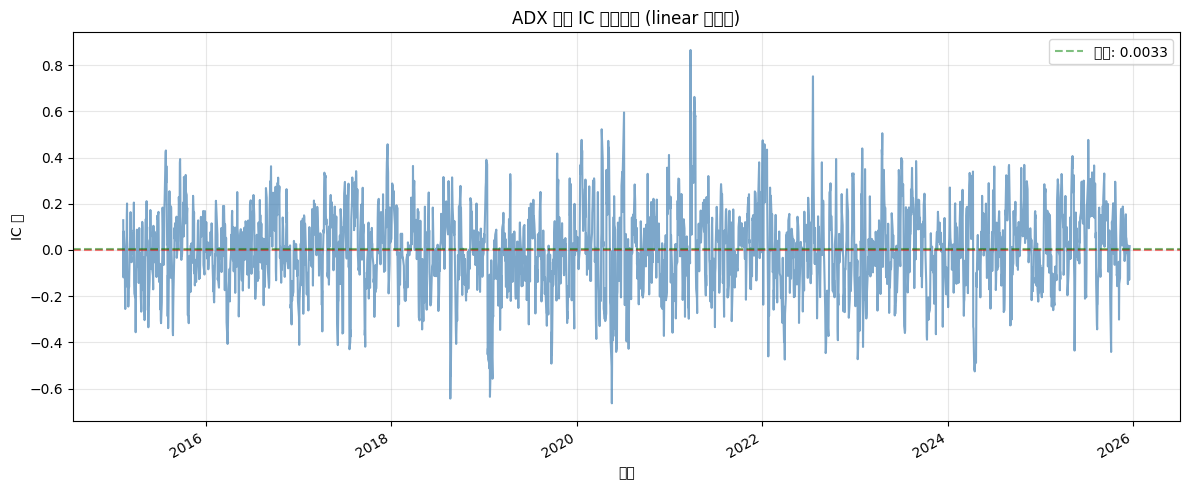

In [17]:
print("=" * 60)
print("IC 分析")
print("=" * 60)

# IC 分析（使用筛选后的因子）
ic_series = calculate_ic(factor_filtered, forward_returns)
ir = calculate_ir(ic_series)

print(f"\nIC 统计:")
print(f"  IC 均值: {ic_series.mean():.4f}")
print(f"  IC 标准差: {ic_series.std():.4f}")
print(f"  IR (信息比率): {ir:.4f}")
print(f"  IC 正比例: {(ic_series > 0).sum() / len(ic_series) * 100:.2f}%")
print(f"  有效观测数: {ic_series.notna().sum()}")

# 可视化 IC
plt.figure(figsize=(12, 5))
ic_series.plot(color='steelblue', alpha=0.7)
plt.axhline(0, color='red', linestyle='--', alpha=0.5)
plt.axhline(ic_series.mean(), color='green', linestyle='--', alpha=0.5, label=f'均值: {ic_series.mean():.4f}')
plt.xlabel("日期")
plt.ylabel("IC 值")
plt.title(f"ADX 因子 IC 时间序列 ({normalize_method} 归一化)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


## 步骤 7: 组合回测


In [18]:
print("=" * 60)
print("组合回测")
print("=" * 60)

# 加载回测配置
backtest_config = load_backtest_config()
costs_config = load_costs_config()

# 从配置文件读取参数
booksize = backtest_config.get('booksize', 1.0)
upper_bound = backtest_config.get('upper_bound', 0.1)
hold_period = backtest_config.get('hold_period', 1)

print(f"回测参数:")
print(f"  组合规模: {booksize}")
print(f"  单只股票最大仓位: {upper_bound*100:.1f}%")
print(f"  持仓天数: {hold_period} 天")
print(f"  交易成本: {costs_config.get('total_cost', 0.0015)*100:.2f}%")

# 运行回测
bt_results = simulate_portfolio(
    alpha=positions,
    prices=data['close'],
    volume=data.get('volume', data['close']),
    costs=costs_config,
    booksize=booksize,
    upper_bound=upper_bound,
    forward_window=hold_period,
    hold_period=hold_period
)

print(f"\n✓ 回测完成")
print(f"  回测天数: {len(bt_results)}")
print(f"  平均每日收益: {bt_results['ret_net'].mean()*100:.4f}%")
print(f"  平均 TVR: {bt_results['tvr'].mean():.4f}")


C:\Users\Chengyu Gong\Klpha\KlphaOriginal\research\backtest\portfolio_bt.py:91: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  forward_returns = prices.pct_change(hold_period).shift(-hold_period)


组合回测
回测参数:
  组合规模: 1.0
  单只股票最大仓位: 10.0%
  持仓天数: 14 天
  交易成本: 0.15%

✓ 回测完成
  回测天数: 2763
  平均每日收益: 0.0736%
  平均 TVR: 0.0072


## 步骤 8: 性能指标


In [19]:
print("=" * 60)
print("性能指标")
print("=" * 60)

# 计算性能指标
metrics = calculate_metrics(bt_results['ret_net'], risk_free_rate=0.0)

print(f"\n回测结果:")
print(f"  年化收益: {metrics['annual_return']*100:.2f}%")
print(f"  年化波动率: {metrics['annual_volatility']*100:.2f}%")
print(f"  夏普比率: {metrics['sharpe_ratio']:.4f}")
print(f"  累计收益: {metrics['cumulative_return']*100:.2f}%")
print(f"  最大回撤: {metrics['max_drawdown']*100:.2f}%")
print(f"  最大回撤持续时间: {metrics['max_drawdown_duration']} 天")
print(f"  胜率: {metrics['win_rate']*100:.2f}%")
print(f"  盈亏比: {metrics['profit_loss_ratio']:.4f}")


性能指标

回测结果:
  年化收益: 18.56%
  年化波动率: 5.41%
  夏普比率: 3.4289
  累计收益: 652.21%
  最大回撤: -29.78%
  最大回撤持续时间: 294 天
  胜率: 63.26%
  盈亏比: 1.0589


## 步骤 9: 可视化


C:\Users\Chengyu Gong\AppData\Local\Temp\ipykernel_31336\2882483230.py:40: UserWarning: Glyph 26085 (\N{CJK UNIFIED IDEOGRAPH-65E5}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Chengyu Gong\AppData\Local\Temp\ipykernel_31336\2882483230.py:40: UserWarning: Glyph 26399 (\N{CJK UNIFIED IDEOGRAPH-671F}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Chengyu Gong\AppData\Local\Temp\ipykernel_31336\2882483230.py:40: UserWarning: Glyph 32047 (\N{CJK UNIFIED IDEOGRAPH-7D2F}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Chengyu Gong\AppData\Local\Temp\ipykernel_31336\2882483230.py:40: UserWarning: Glyph 35745 (\N{CJK UNIFIED IDEOGRAPH-8BA1}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Chengyu Gong\AppData\Local\Temp\ipykernel_31336\2882483230.py:40: UserWarning: Glyph 25910 (\N{CJK UNIFIED IDEOGRAPH-6536}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Chengyu Gong\AppData\Local\Temp\ipykernel_31336\288

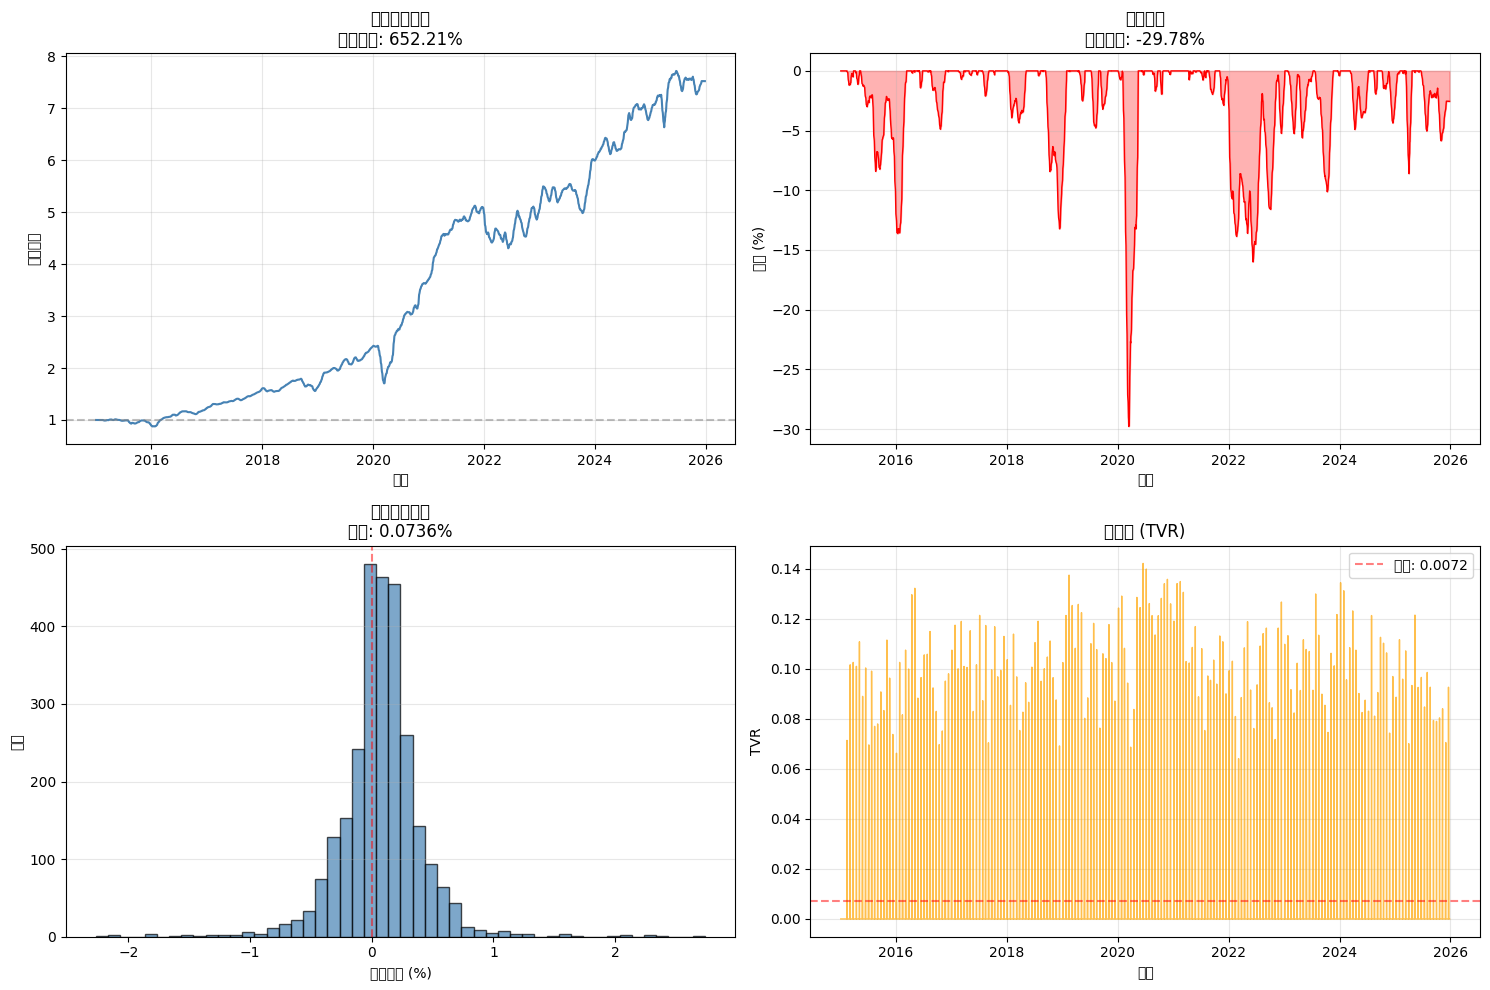

✓ 图表生成完成


In [20]:
# 可视化回测结果
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. 累计收益曲线
cumulative_ret = (1 + bt_results['ret_net']).cumprod()
axes[0, 0].plot(cumulative_ret.index, cumulative_ret.values, color='steelblue', linewidth=1.5)
axes[0, 0].axhline(1, color='gray', linestyle='--', alpha=0.5)
axes[0, 0].set_title(f'累计收益曲线\n最终收益: {metrics["cumulative_return"]*100:.2f}%')
axes[0, 0].set_xlabel('日期')
axes[0, 0].set_ylabel('累计收益')
axes[0, 0].grid(True, alpha=0.3)

# 2. 回撤曲线
drawdown = (cumulative_ret / cumulative_ret.expanding().max() - 1) * 100
axes[0, 1].fill_between(drawdown.index, drawdown.values, 0, color='red', alpha=0.3)
axes[0, 1].plot(drawdown.index, drawdown.values, color='red', linewidth=1)
axes[0, 1].set_title(f'回撤曲线\n最大回撤: {metrics["max_drawdown"]*100:.2f}%')
axes[0, 1].set_xlabel('日期')
axes[0, 1].set_ylabel('回撤 (%)')
axes[0, 1].grid(True, alpha=0.3)

# 3. 每日收益分布
axes[1, 0].hist(bt_results['ret_net'].dropna() * 100, bins=50, edgecolor='black', alpha=0.7, color='steelblue')
axes[1, 0].axvline(0, color='red', linestyle='--', alpha=0.5)
axes[1, 0].set_title(f'每日收益分布\n均值: {bt_results["ret_net"].mean()*100:.4f}%')
axes[1, 0].set_xlabel('每日收益 (%)')
axes[1, 0].set_ylabel('频率')
axes[1, 0].grid(True, alpha=0.3, axis='y')

# 4. TVR (换手率)
axes[1, 1].plot(bt_results.index, bt_results['tvr'], color='orange', alpha=0.7, linewidth=1)
axes[1, 1].axhline(bt_results['tvr'].mean(), color='red', linestyle='--', alpha=0.5, 
                   label=f'均值: {bt_results["tvr"].mean():.4f}')
axes[1, 1].set_title('换手率 (TVR)')
axes[1, 1].set_xlabel('日期')
axes[1, 1].set_ylabel('TVR')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("✓ 图表生成完成")
